# Clustering Lab

 
Based of the amazing work you did in the Movie Industry you've been recruited to the NBA! You are working as the VP of Analytics that helps support a head scout, Mr. Rooney, for the worst team in the NBA probably the Wizards. Mr. Rooney just heard about Data Science and thinks it can solve all the team's problems!!! He wants you to figure out a way to find players that are high performing but maybe not highly paid that you can steal to get the team to the playoffs!

In this document you will work through a similar process that we did in class with the NBA data (NBA_Perf_22 and nba_salaries_22), merging them together. This is from 22-23 season, feel free to update to 2023-24 season if you want.

Data Sources:
https://www.basketball-reference.com/leagues/NBA_2024_totals.html # reference for performance data https://www.basketball-reference.com/contracts/players.html # reference for salary data

Details:

Determine a way to use clustering to estimate based on performance if players are under or over paid, generally.

Then select players you believe would be best for your team and explain why. Do so in three categories:

Examples that are not good choices (3 or 4)
Several options that are good choices (3 or 4)
Several options that could work, assuming you can't get the players in the good category (3 or 4)
You will decide the cutoffs for each category, so you should be able to explain why you chose them.

Provide a well commented and clean report of your findings in a separate notebook that can be presented to Mr. Rooney, keeping in mind he doesn't understand...anything. Include a rationale for variables you included in the model, details on your approach and a overview of the results with supporting visualizations.

Hints:

Salary is the variable you are trying to understand
When interpreting you might want to use graphs that include variables that are the most correlated with Salary
You'll need to scale the variables before performing the clustering
Be specific about why you selected the players that you did, more detail is better
Use good coding practices, comment heavily, indent, don't use for loops unless totally necessary and create modular sections that align with some outcome. If necessary create more than one script,list/load libraries at the top and don't include libraries that aren't used.
Be careful for non-traditional characters in the players names, certain graphs won't work when these characters are included.


In [97]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import silhouette_score
import plotly.express as px
import plotly.graph_objects as go


In [262]:
import os
print(os.getcwd())
print(os.listdir())

/Users/anayanath/rainbow/DS-3021-analytics-1/10_kMeans Clustering
['clr_cluster.jpeg', 'Manual Variance Explained.xlsx', 'nba_salaries_22.csv', 'cluster_no_color.png', 'US House Votes for Dem Bills.png', 'Clustering_InClass_9.28.21.pptx', 'NBA_Perf_22.csv', 'Lab-Clustering.ipynb', 'Clustering_InClass_9.28.21.pdf', 'cluster_example.py']


In [263]:
import pandas as pd

perf = pd.read_csv("/Users/anayanath/rainbow/DS-3021-analytics-1/10_kMeans Clustering/NBA_Perf_22.csv", encoding='latin1')
salaries = pd.read_csv("/Users/anayanath/rainbow/DS-3021-analytics-1/10_kMeans Clustering/nba_salaries_22.csv", encoding='latin1')


In [264]:
salaries.columns = ['Player', 'Salary']

# removing $ and converting salary to float
salaries['Salary'] = salaries['Salary'].replace(r'[$,]', '', regex=True).astype(float)

# Dropping unnecessary columns from performance data
perf_clean = perf.drop(columns=[
    'Pos'        #position not needed because there were many position overlaps and it complicates one hot encoded
   'Tm',         # Team name not needed
   'GS',         # Games started is redundant with minutes played
   '2P', '2PA', '2P%',  # 2-point stats are part of FG and not needed separately
  'eFG%',       # Composite shooting stat, we use FG% and 3P% directly
  'Rk'  ,       #row index not useful
   'Awards'      #dropped awads as there are too many null values and the rest are distinct strings
     
], errors='ignore')




# Cleaning player names (remove asterisks or trailing spaces)
perf_clean['Player'] = perf_clean['Player'].str.replace('*', '', regex=False).str.strip()
salaries['Player'] = salaries['Player'].str.replace('*', '', regex=False).str.strip()

# Merging cleaned datasets on Player name
nba = pd.merge(perf_clean, salaries, on='Player', how='inner')

#merged dataset
nba.head()



,Player,Pos,Age,Tm,G,MP,FG,FGA,FG%,3P,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Salary
0,Precious Achiuwa,C,22,TOR,73,23.6,3.6,8.3,0.439,0.8,...,2.0,4.5,6.5,1.1,0.5,0.6,1.2,2.1,9.1,2840160.0
1,Steven Adams,C,28,MEM,76,26.3,2.8,5.1,0.547,0.0,...,4.6,5.4,10.0,3.4,0.9,0.8,1.5,2.0,6.9,17926829.0
2,Bam Adebayo,C,24,MIA,56,32.6,7.3,13.0,0.557,0.0,...,2.4,7.6,10.1,3.4,1.4,0.8,2.6,3.1,19.1,30351780.0
3,Santi Aldama,PF,21,MEM,32,11.3,1.7,4.1,0.402,0.2,...,1.0,1.7,2.7,0.7,0.2,0.3,0.5,1.1,4.1,2094120.0
4,Nickeil Alexander-Walker,SG,23,TOT,65,22.6,3.9,10.5,0.372,1.6,...,0.6,2.3,2.9,2.4,0.7,0.4,1.4,1.6,10.6,5009633.0


In [265]:
#Run the clustering algo with your best guess for K
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd

def run_kmeans_clustering(nba_df, features, k):
    """
    Runs KMeans clustering on the given NBA dataframe using the selected features and k clusters.

    Returns:
    - clustered_df: original data with 'Cluster' column
    - clust_scaled: scaled feature data (for evaluation)
    - kmeans: trained KMeans model (for inertia and labels)
    """
    # clean and scale data
    clust_data = nba_df[features].dropna()
    scaler = StandardScaler()
    clust_scaled = scaler.fit_transform(clust_data)

    # Run KMeans
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(clust_scaled)

    # Attach cluster labels
    clustered_df = nba_df.loc[clust_data.index].copy()
    clustered_df['Cluster'] = kmeans.labels_

    #  cluster summary
    print(f"\n KMeans Clustering Results (k={k})")
    print("Cluster Centers:\n", kmeans.cluster_centers_)
    print("\nSample Players:\n", clustered_df[['Player', 'Salary', 'Cluster'] + features].sort_values('Cluster').head(10))
    print("\nCluster Summary:\n", clustered_df.groupby('Cluster')[features + ['Salary']].mean())
    print("\nPlayers per Cluster:\n", clustered_df['Cluster'].value_counts())

    return clustered_df, clust_scaled, kmeans

features = ['PTS', 'AST', 'ORB','DRB', 'STL', 'BLK', 'FG%', '3P%', 'FT%', 'G', 'PF', 'TOV']
nba_clustered_4, clust_data_scaled, kmeans_nba = run_kmeans_clustering(nba, features, k=4)
##I chose 4 clusters because my assumption is that players can be classified into 4 groups: elite performers, reliable contributers
#to the team, specific contributers (eg a shooter, defense player), and minimal players (limited contribution to team's success)
print(f"Inertia (WCSS) for k={kmeans_nba.n_clusters}:", round(kmeans_nba.inertia_, 2))


 KMeans Clustering Results (k=4)
Cluster Centers:
 [[-0.92282161 -0.6756986  -0.58245706 -0.89128894 -0.87349191 -0.59114392
  -0.47503735  0.01799299 -0.11012055 -0.62752789 -1.05192587 -0.80158392]
 [-0.16031704 -0.4845531   1.42181446  0.63471313 -0.29758313  1.09750958
   1.21755019 -0.69906494 -0.71735439 -0.04793862  0.60425583 -0.22532197]
 [ 1.69289302  1.89237085  0.13007412  1.16513949  1.22685695  0.13836426
   0.02663751  0.12885922  0.37099757  0.24139137  0.80558005  1.99977208]
 [ 0.10907284  0.02797417 -0.32769529 -0.10596345  0.30212329 -0.17121221
  -0.26722712  0.2743288   0.28513238  0.35981177  0.14043185 -0.04751041]]

Sample Players:
               Player     Salary  Cluster  PTS  AST  ORB  DRB  STL  BLK    FG%  \
358      Daishen Nix  1563518.0        0  3.2  1.7  0.3  1.1  0.6  0.0  0.403   
330      Sam Merrill   150000.0        0  4.2  0.7  0.2  1.0  0.0  0.0  0.333   
155     Usman Garuba  2471160.0        0  2.0  0.7  0.9  2.6  0.4  0.5  0.432   
339      

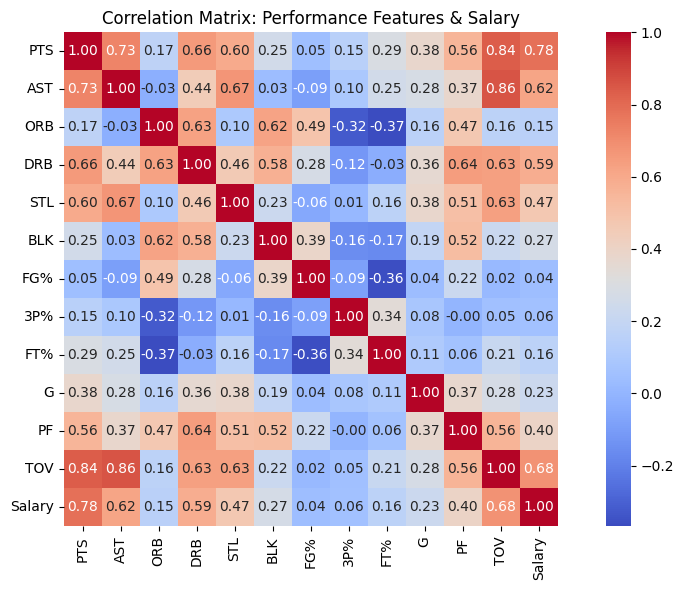

In [266]:
# Adding 'Salary' to the list of features to analyze
features_with_salary = features + ['Salary']

# correlation matrix
corr_matrix = nba[features_with_salary].corr()

# heatmap plot 
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix: Performance Features & Salary")
plt.tight_layout()
plt.show()


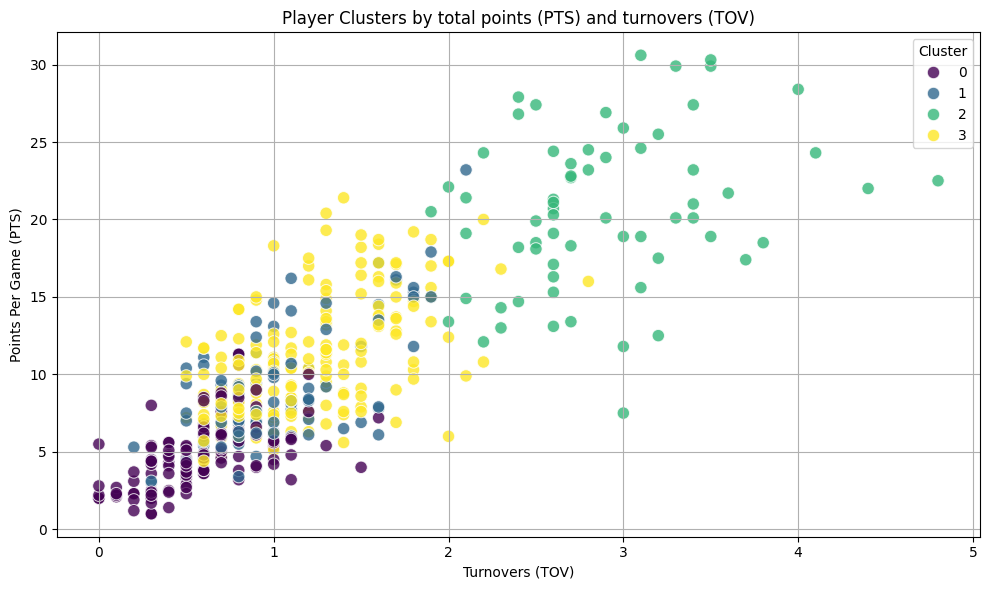

In [267]:
#Create a visualization of the results with 2 or 3 variables that you think will best
#differentiate the clusters

#Two variables I chose to explore:
#PTS: Represents a player’s scoring volume, a key measure of offensive performance.
#FG%: Captures scoring efficiency, showing how effectively a player turns shots into points.
plt.figure(figsize=(10, 6))

# Scatterplot of players by FG% and PTS, colored by cluster
sns.scatterplot(
    data=nba_clustered_4,
    x='TOV',
    y='PTS',
    hue='Cluster',
    palette='viridis',
    alpha=0.8,
    s=80  # fixed size since I am not using salary
)

plt.title('Player Clusters by total points (PTS) and turnovers (TOV)')
plt.xlabel('Turnovers (TOV)')
plt.ylabel('Points Per Game (PTS)')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

In [268]:
#Evaluate the quality of the clustering using total variance explained and silhouette scores

# total variance (Total Sum of Squares)
total_sum_squares = np.sum((clust_data_scaled - np.mean(clust_data_scaled, axis=0))**2)
total = np.sum(total_sum_squares)

# between-cluster sum of squares (explained variance)
between_SSE = total - kmeans_nba.inertia_

# variance explained
variance_explained = between_SSE / total
print("Total Variance Explained:", round(variance_explained, 4))



Total Variance Explained: 0.4278


In [269]:
sil_score = silhouette_score(clust_data_scaled, kmeans_nba.labels_)
print("Silhouette Score:", round(sil_score, 4))

Silhouette Score: 0.1704


In [270]:
#Determine the ideal number of clusters using the elbow method and the silhouette coefficient# Initialize lists

wcss = []  # Within-cluster sum of squares
silhouette_scores = []

# Range of k values to try
k_range = range(2, 11)

# KMeans for each k 
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(clust_data_scaled)
    wcss.append(kmeans.inertia_)

# silhouette scores 
for k in k_range:
    kmeans = KMeans(n_clusters=k, algorithm="lloyd", random_state=1)
    kmeans.fit(clust_data_scaled)
    silhouette_scores.append(silhouette_score(clust_data_scaled, kmeans.labels_))

#best number of clusters based on silhouette score
best_k = silhouette_scores.index(max(silhouette_scores)) + 2  # +2 because we started from k=2
print(f"Best number of clusters by silhouette score: {best_k}")

# Store results 
elbow_df = pd.DataFrame({"k": range(1, 11), "wcss": wcss})
silhouette_df = pd.DataFrame({"k": list(k_range), "silhouette_score": silhouette_scores})

Best number of clusters by silhouette score: 3


In [271]:
#Visualize results -elbow method
# Plot 
fig = px.line(
    elbow_df,
    x="k",
    y="wcss",
    title="Elbow Method for Optimal k (NBA Player Clustering)"
)
fig.update_layout(
    xaxis_title="Number of Clusters (k)",
    yaxis_title="Within-Cluster Sum of Squares (WCSS)"
)

fig.show(renderer="browser")  # Opens in your browser


 KMeans Clustering Results (k=3)
Cluster Centers:
 [[-0.50613753 -0.40246137 -0.48053601 -0.54992231 -0.4107938  -0.45395028
  -0.37163351  0.14990984  0.08813588 -0.14609508 -0.56859762 -0.51228462]
 [-0.11898965 -0.44428333  1.26513057  0.60905188 -0.04546977  1.07443722
   1.0623525  -0.59720758 -0.6590644   0.0816255   0.62838695 -0.20172776]
 [ 1.29761463  1.36544142 -0.08290732  0.70540176  1.00441537  0.03684268
  -0.14420288  0.21910623  0.42264264  0.26390086  0.73064358  1.39093822]]

Sample Players:
                 Player      Salary  Cluster   PTS  AST  ORB  DRB  STL  BLK  \
395  Immanuel Quickley   2316240.0        0  11.3  3.5  0.4  2.8  0.7  0.0   
365      Royce O'Neale   9200000.0        0   7.4  2.5  0.8  3.9  1.1  0.4   
364       Jordan Nwora   3000000.0        0   7.9  1.0  0.6  3.0  0.4  0.3   
363        David Nwaba   5022000.0        0   5.1  0.8  0.9  2.4  0.6  0.4   
362    Frank Ntilikina   2036318.0        0   4.1  1.2  0.2  1.2  0.5  0.1   
361      Jayle

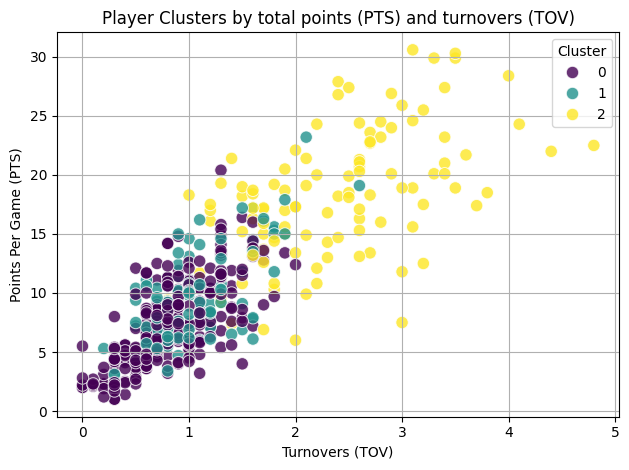

In [272]:
#Use the recommended number of cluster (assuming it's different) to retrain your model and visualize the results
nba_clustered_3, clust_data_scaled, kmeans_nba = run_kmeans_clustering(nba, features, k=3)
print(f"Inertia (WCSS) for k={kmeans_nba.n_clusters}:", round(kmeans_nba.inertia_, 3))
sns.scatterplot(
    data=nba_clustered_3,
    x='TOV',
    y='PTS',
    hue='Cluster',
    palette='viridis',
    alpha=0.8,
    s=80  # fixed size since we're not using salary
)

plt.title('Player Clusters by total points (PTS) and turnovers (TOV)')
plt.xlabel('Turnovers (TOV)')
plt.ylabel('Points Per Game (PTS)')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()


In [273]:
#Once again evaluate the quality of the clustering using total variance explained and silhouette scores
# Total variance explained
total_sum_squares = np.sum((clust_data_scaled - np.mean(clust_data_scaled, axis=0))**2)
between_SSE = total_sum_squares - kmeans_nba.inertia_
variance_explained = between_SSE / total_sum_squares
print("Total Variance Explained:", round(variance_explained, 4))

#Silhouette score
sil_score = silhouette_score(clust_data_scaled, kmeans_nba.labels_)
print(" Silhouette Score:", round(sil_score, 4))

Total Variance Explained: 0.3533
 Silhouette Score: 0.233


In [274]:
#Use the model to select players for Mr. Rooney to consider
cluster_summary = nba_clustered_3.groupby('Cluster')[features + ['Salary']].mean()
display(cluster_summary)
high_perf_cluster = 2
avg_salary = 20010960  # from your summary

# Filter players in that cluster
players_in_cluster_3 = nba_clustered_3[nba_clustered_3['Cluster'] == high_perf_cluster]

# Find undervalued players in this elite group
undervalued = players_in_cluster_3[players_in_cluster_3['Salary'] < avg_salary]

# Sort by performance (e.g., Points Per Game)
undervalued_sorted = undervalued.sort_values('PTS', ascending=False)

# Display the top candidates
undervalued_sorted[['Player', 'Salary', 'PTS', 'AST', 'FG%', 'Cluster']].head(10)

,PTS,AST,ORB,DRB,STL,BLK,FG%,3P%,FT%,G,PF,TOV,Salary
Cluster,,,,,,,,,,,,,
0,7.326667,1.567451,0.591765,2.195686,0.565098,0.273725,0.433059,0.344455,0.776498,47.705882,1.443922,0.814902,5.565562e+06
1,9.665385,1.485577,1.864423,4.188462,0.706731,0.829808,0.539644,0.264971,0.691048,52.480769,2.274038,1.071154,8.787213e+06
2,18.222936,5.028440,0.881651,4.354128,1.113761,0.452294,0.449963,0.351817,0.814752,56.302752,2.344954,2.385321,2.013573e+07


,Player,Salary,PTS,AST,FG%,Cluster
340,Ja Morant,12119440.0,27.4,6.7,0.493,2
154,Darius Garland,8920795.0,21.7,8.6,0.462,2
390,Norman Powell,16758621.0,21.4,2.8,0.508,2
126,Anthony Edwards,10733400.0,21.3,3.8,0.441,2
348,Dejounte Murray,16571120.0,21.1,9.2,0.462,2
202,Tyler Herro,5722116.0,20.7,4.0,0.447,2
25,LaMelo Ball,8623920.0,20.1,7.6,0.429,2
32,RJ Barrett,10900635.0,20.0,3.0,0.408,2
195,Josh Hart,12960000.0,19.9,4.3,0.503,2
388,Norman Powell,16758621.0,19.0,2.1,0.461,2


In [247]:
undervalued_clean = undervalued_sorted.drop_duplicates(subset='Player').copy()

# Step 2: Add cluster average salary column (constant for all rows)
cluster_avg_salary = 20010960  # from your earlier summary
undervalued_clean['Cluster Avg Salary'] = cluster_avg_salary


# Step 4: Select and display cleaned table
display_cols = ['Player', 'Salary', 'Cluster Avg Salary', 'PTS', 'AST', 'FG%', 'Cluster']
undervalued_clean[display_cols].head(10)

,Player,Salary,Cluster Avg Salary,PTS,AST,FG%,Cluster
340,Ja Morant,12119440.0,20010960,27.4,6.7,0.493,2
154,Darius Garland,8920795.0,20010960,21.7,8.6,0.462,2
390,Norman Powell,16758621.0,20010960,21.4,2.8,0.508,2
126,Anthony Edwards,10733400.0,20010960,21.3,3.8,0.441,2
348,Dejounte Murray,16571120.0,20010960,21.1,9.2,0.462,2
202,Tyler Herro,5722116.0,20010960,20.7,4.0,0.447,2
25,LaMelo Ball,8623920.0,20010960,20.1,7.6,0.429,2
32,RJ Barrett,10900635.0,20010960,20.0,3.0,0.408,2
195,Josh Hart,12960000.0,20010960,19.9,4.3,0.503,2
421,Domantas Sabonis,18500000.0,20010960,18.9,5.8,0.554,2


Write up the results in a separate notebook with supporting visualizations and
an overview of how and why you made the choices you did. This should be at least 500 words and should be written for a non-technical audience.